In [205]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)
print("Current code version, ", __version__)

Current code version,  73


In [207]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "68"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(3)

,experiment_id,experiment_name,duration,problem_types,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,test_against_largest_epsilon,lambdas,taus,ps,dp,d,experiment_type,completed,data_model_type,data_model_name,data_model_description
3,1b72be30-1c6e-412e-b92a-2387d5768d16,Sweep Alpha - VanillaGaussian - VanillaGaussia...,192.399604,"[""Ridge"", ""Logistic""]",73,2023-11-13 10:18:20,1,2,"[0.5, 3.25, 6.0]","[0.0, 0.5]",1,[0.01],[0],null,0.01,1000,Sweep,1,VanillaGaussian,VanillaGaussian,A Data-Model with Identity Gaussians for all t...
1,cbfe1c9c-8d2d-4efe-84b7-986e817a39de,Sweep Alpha - VanillaGaussian - VanillaGaussia...,196.575296,"[""Ridge"", ""Logistic""]",73,2023-11-13 10:08:51,1,2,"[0.5, 3.25, 6.0]","[0.0, 0.5]",1,[0.01],[0],null,0.01,1000,Sweep,1,VanillaGaussian,VanillaGaussian,A Data-Model with Identity Gaussians for all t...
0,f321b607-6121-47de-a2a4-44fe98b38e93,Sweep Alpha - VanillaGaussian - VanillaGaussia...,198.663853,"[""Ridge"", ""Logistic""]",73,2023-11-13 10:04:07,1,2,"[0.5, 3.25, 6.0]","[0.0, 0.5]",1,[0.01],[0],null,0.01,1000,Sweep,1,VanillaGaussian,VanillaGaussian,A Data-Model with Identity Gaussians for all t...


In [208]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [209]:
experiment_loc = 0

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the data model type and data_model name used
data_model_type = df_experiments.iloc[experiment_loc]["data_model_type"]
# convert it to the enum
data_model_type = DataModelType[data_model_type]
data_model_name = df_experiments.iloc[experiment_loc]["data_model_name"]
data_model_description = df_experiments.iloc[experiment_loc]["data_model_description"]
print(data_model_type.name, data_model_name)
print(data_model_description)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

1b72be30-1c6e-412e-b92a-2387d5768d16
VanillaGaussian VanillaGaussian
A Data-Model with Identity Gaussians for all the covariances.
Sweep Alpha - VanillaGaussian - VanillaGaussian - A Data-Model with Identity Gaussians for all the covariances.
['Ridge', 'Logistic']


In [210]:
round_to = 1
def my_floor(a, precision=round_to):
    return np.round(a - 0.5 * 10**(-precision), precision)
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]

gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: my_floor(x,precision=round_to))


# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type"]) #,"p_calibration"
# from state_evolution keep generalization_error, sigma, q, m, angle
state_evolution = state_evolution[["generalization_error","sigma","q","Q_self","m","angle","training_loss","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error","A","N","A_hat","N_hat","test_loss", "robustness", "teacher_robustness","adversarial_generalization_error_teacher"]] #calibration
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	angle
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","angle", "training_error","d", "training_loss","test_loss","adversarial_generalization_error","adversarial_generalization_error_overlap","A","N", "robustness", "teacher_robustness","adversarial_generalization_error_teacher"]] #,"erm_calibration","analytical_calibration"
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm',"Q_self_state_evolution",'m_state_evolution','m_erm','angle_state_evolution','angle_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm","training_error_state_evolution","A_erm","N_erm","A_state_evolution","N_state_evolution","A_hat_state_evolution","N_hat_state_evolution","test_loss_state_evolution", "robustness_erm", "teacher_robustness_erm", "robustness_state_evolution", "teacher_robustness_state_evolution","adversarial_generalization_error_teacher_erm","adversarial_generalization_error_teacher_state_evolution"]] #,"erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution"
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3,4]).agg(["mean","std"]) #,4
# display all columns
pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df.sort_index()
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_29273/3553651151.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: my_floor(x,precision=round_to))


generalization_error_state_evolution       \
                                                                    mean  std   
alpha epsilon tau lam  problem_type                                             
0.4   0.0     0.0 0.01 Logistic                                 0.322914  0.0   
                       Ridge                                    0.337757  0.0   
      0.5     0.0 0.01 Logistic                                 0.323244  0.0   
                       Ridge                                    0.336677  0.0   
3.2   0.0     0.0 0.01 Logistic                                 0.121858  0.0   
                       Ridge                                    0.148295  0.0   
      0.5     0.0 0.01 Logistic                                 0.136228  0.0   
                       Ridge                                    0.145467  0.0   
6.0   0.0     0.0 0.01 Logistic                                 0.072242  0.0   
                       Ridge                                    0.103696  0.0   
      0.5     0.0 0.01 Logistic                                 0.100188  0.0   
                       Ridge                                    0.107761  0.0   

                                    generalization_error_erm_erm            \
                                                            mean       std   
alpha epsilon tau lam  problem_type                                          
0.4   0.0     0.0 0.01 Logistic                         0.318570  0.001626   
                       Ridge                            0.334675  0.000219   
      0.5     0.0 0.01 Logistic                         0.323880  0.008273   
                       Ridge                            0.336585  0.006767   
3.2   0.0     0.0 0.01 Logistic                         0.121920  0.001047   
                       Ridge                            0.146745  0.001549   
      0.5     0.0 0.01 Logistic                         0.137295  0.006102   
                       Ridge                            0.142850  0.006633   
6.0   0.0     0.0 0.01 Logistic                         0.073180  0.002192   
                       Ridge                            0.106260  0.000127   
      0.5     0.0 0.01 Logistic                         0.099925  0.000983   
                       Ridge                            0.110905  0.001563   

                                    generalization_error_overlap_erm  \
                                                                mean   
alpha epsilon tau lam  problem_type                                    
0.4   0.0     0.0 0.01 Logistic                             0.318222   
                       Ridge                                0.335408   
      0.5     0.0 0.01 Logistic                             0.321615   
                       Ridge                                0.337347   
3.2   0.0     0.0 0.01 Logistic                             0.121422   
                       Ridge                                0.146850   
      0.5     0.0 0.01 Logistic                             0.136059   
                       Ridge                                0.142309   
6.0   0.0     0.0 0.01 Logistic                             0.072989   
                       Ridge                                0.105206   
      0.5     0.0 0.01 Logistic                             0.098875   
                       Ridge                                0.110431   

                                              sigma_state_evolution       \
                                          std                  mean  std   
alpha epsilon tau lam  problem_type                                        
0.4   0.0     0.0 0.01 Logistic      0.002622             67.588241  0.0   
                       Ridge         0.002066             50.962136  0.0   
      0.5     0.0 0.01 Logistic      0.007600             40.631051  0.0   
                       Ridge         0.005079             30.314617  0.0   
3.2   0.0     0.0 0.01 Logistic     

In [211]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [212]:
first_iteration = "tau"
second_iteration = "lam" # "lam"
target = "alpha"
sweep = "epsilon"
save_plots = False
description = ""
def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None):
    df2 = df.reset_index()
    df2.sort_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]


    for problem_type in df2["problem_type"].unique():

        for tau in df2[first_iteration].unique():

            iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

            for lam in iterate_over:

                fig = plt.figure()
                ax = plt.subplot(111)

                # Filter the dataframe for the current values of tau and lam
                if second_iteration is None:
                    data = df2[(df2[first_iteration] == tau) & (df2["problem_type"] == problem_type)]
                else:
                    data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam) & (df2["problem_type"] == problem_type)]

                if fix_a_variable is not None:
                    data = data[data[fix_a_variable] == variable_value]
                
                for i, epsilon in enumerate(data[sweep].unique()):
                    # Filter the dataframe for the current value of epsilon
                    epsilon_subset = data[data[sweep] == epsilon]

                    # Plot the state_evolution results as a line
                    if state_evolution_name is not None:
                        if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                            ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                        else:
                            ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon:.4f}', color=palette[i])
                    
                    # Plot the gradient_descent results as points with error bars
                    if gd_name is not None:
                        try:
                            ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                        except:
                            pass

                    if error_name == "Generalization Error" and target == "lam":
                        optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name)
                        # plot the optimal lambda as a vertical line
                        if optimal_lambda is not None:
                            ax.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

                
                if log_x:
                    plt.xscale('log')
                    # plt.xscale('symlog')
                if log_y:
                    plt.yscale('log')

                # Add labels and title
                plt.xlabel(target)
                plt.ylabel(error_name)
                if fix_a_variable is not None:
                    if second_iteration is None:
                        plt.title(f'{error_name} - {problem_type} - {first_iteration}: {tau}, d: {d} - {fix_a_variable}: {variable_value}',y=1.1)
                    else:
                        plt.title(f'{error_name} - {problem_type} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}',y=1.1)
                else:
                    if second_iteration is None:
                        plt.title(f'{error_name} - {problem_type} - {first_iteration}: {tau}, d: {d}',y=1.1)
                    else:
                        plt.title(f'{error_name} - {problem_type} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d}',y=1.1)
                

                box = ax.get_position()
                ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                # Put a legend to the right of the current axis
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                # add a grid
                plt.grid()

                plt.tight_layout()

                if fix_a_variable is not None:
                    name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
                else:
                    name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
                # Save the plot as svg
                if filename is not None or save_plots:


                    # make sure the directory for the data_model_name exists
                    directory = f"Assets/{data_model_name}"
                    if not os.path.exists(directory):
                        os.makedirs(directory)

                    # encode the sweep type as a directory
                    sweep_name = f"x_{target}_different_{sweep}_many_{second_iteration}"
                    directory = f"Assets/{data_model_name}/{sweep_name}"
                    if not os.path.exists(directory):
                        os.makedirs(directory)

                    # encode the problem type as a directory
                    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}"
                    if not os.path.exists(directory):
                        os.makedirs(directory)

                    if save_plots and filename is None:
                        filename = description

                    plt.savefig(f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}_{name}.pdf", bbox_inches='tight')

                # Show the plot
                plt.show()

In [213]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

In [214]:
# create_plot(df,"Optimal Lambda", "lam", None,filename="Optimal_lambda")

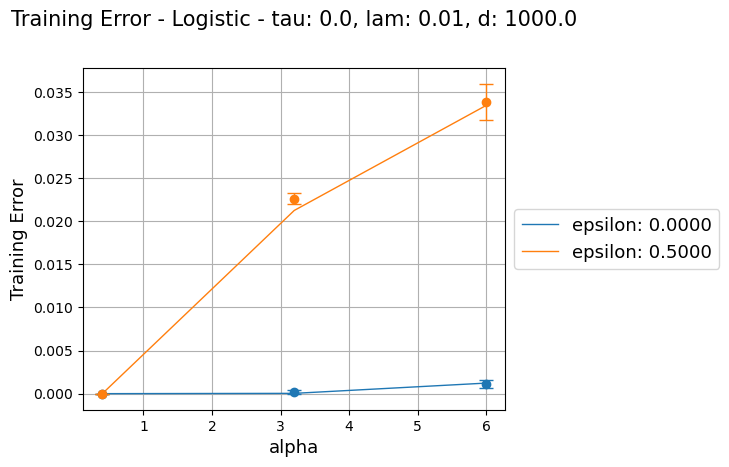

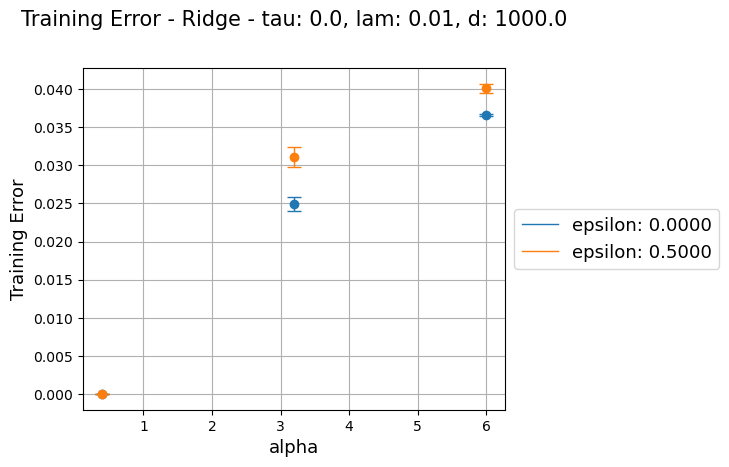

In [215]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm",log_y=False,log_x=False)

In [216]:
# # Let's add a new column to the dataframe for the training error in terms of erm overlaps, except for sigma

# df.apply()

# training_error_overlaps: float = training_error_logistic(m,Q,sigma,A,N,rho,n/d,tau,epsilon, lam)

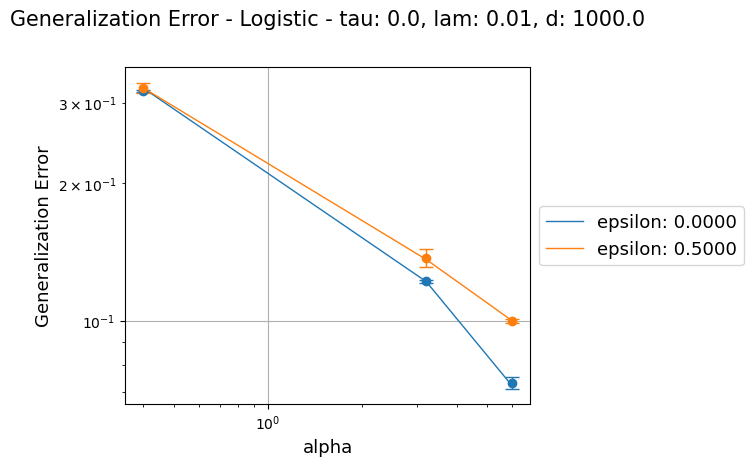

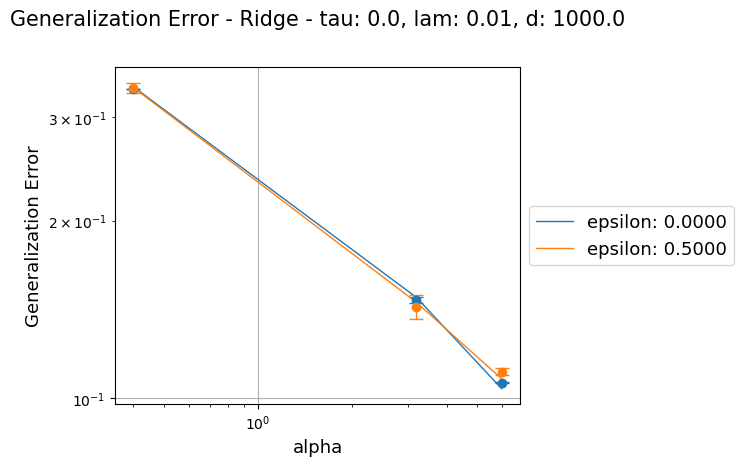

In [217]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=True)

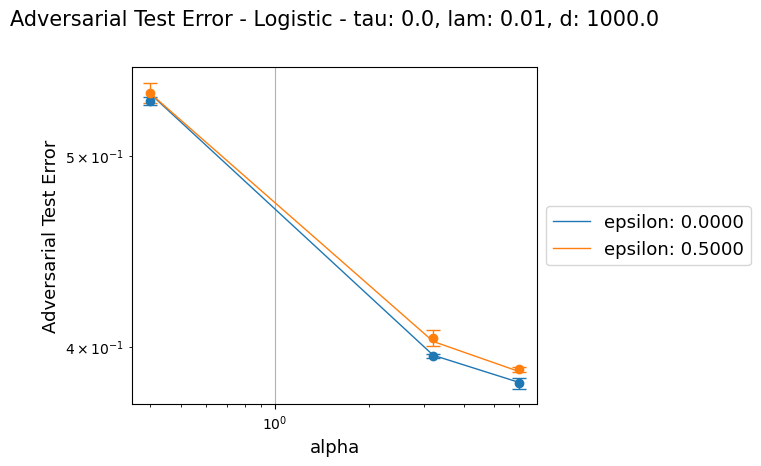

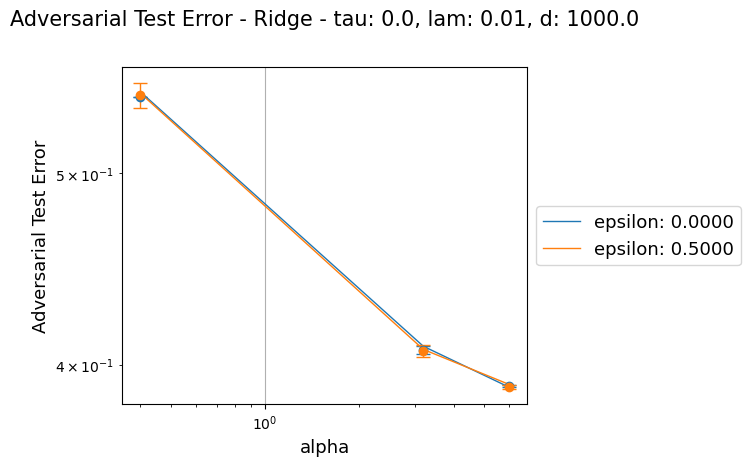

In [218]:
create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm",log_y=True,log_x=True)

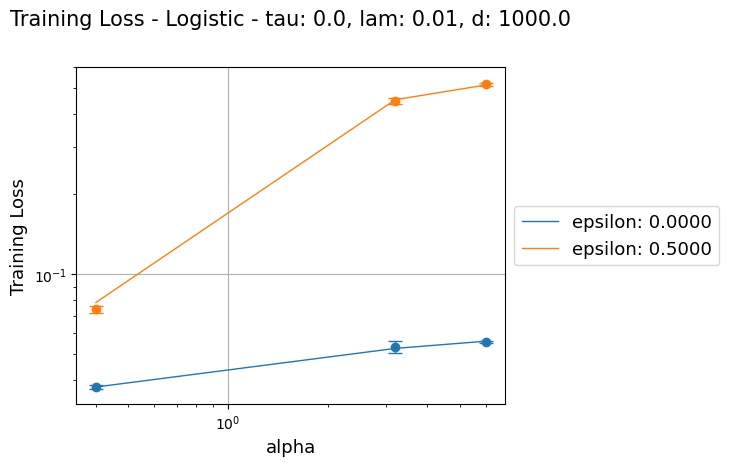

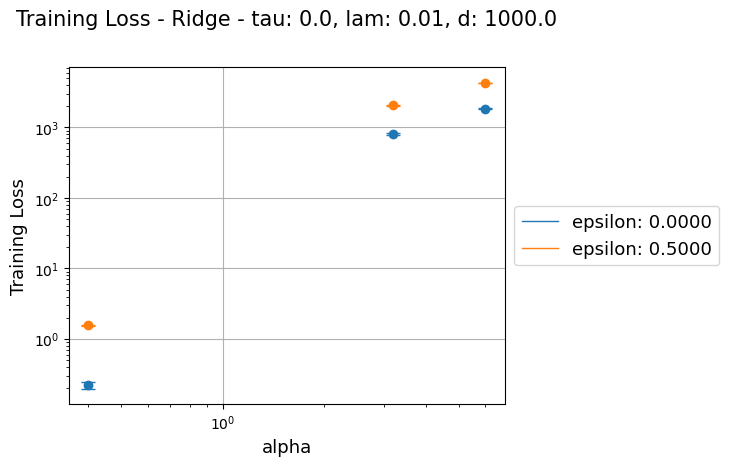

In [219]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

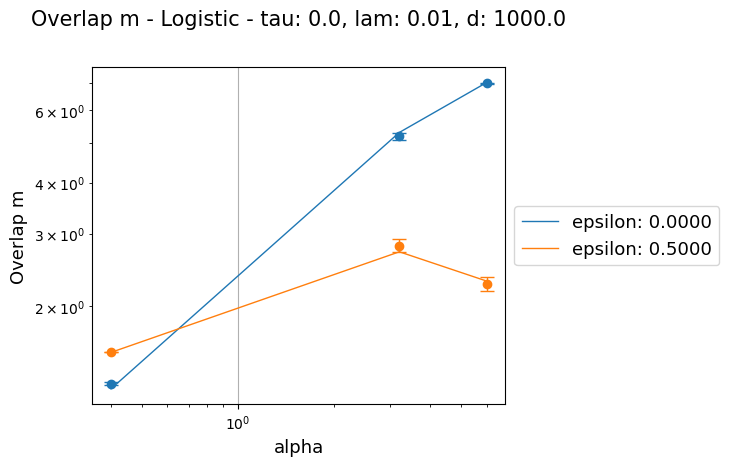

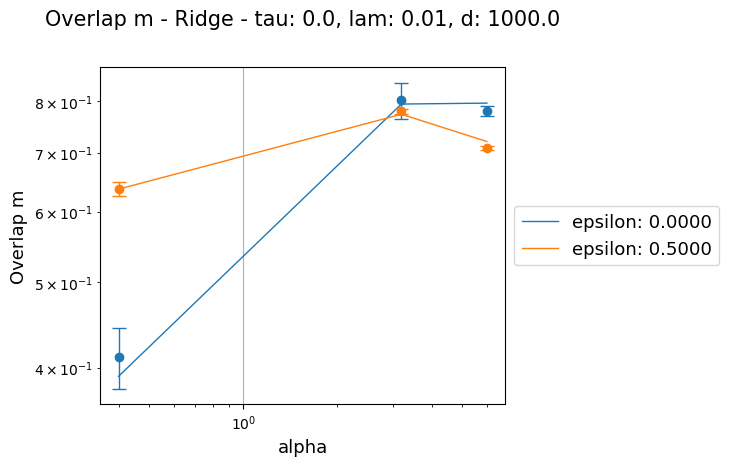

In [220]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm")

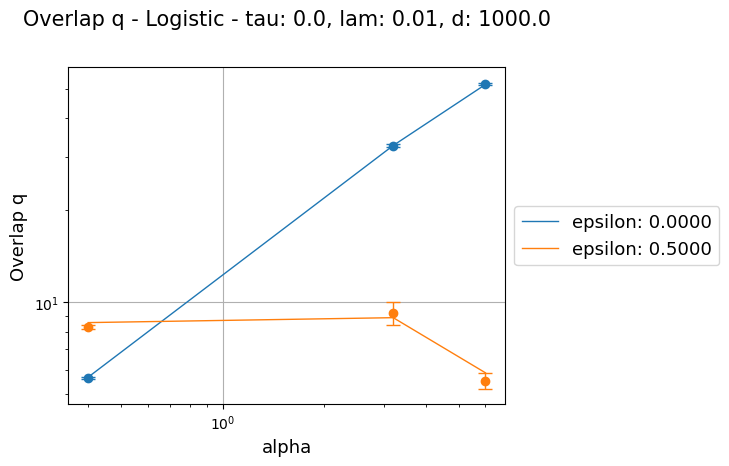

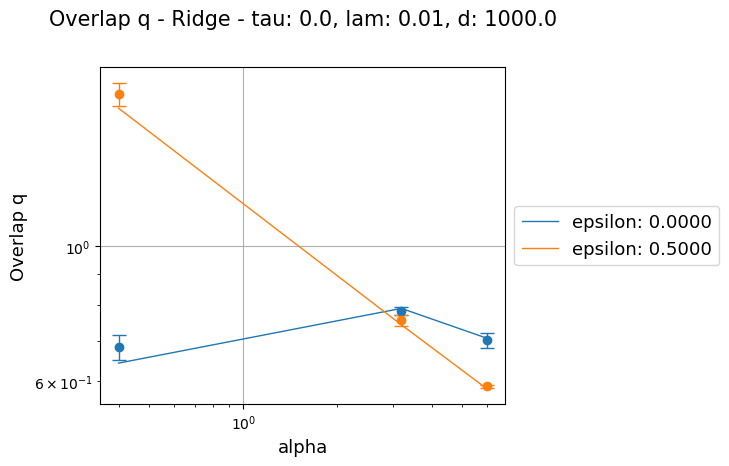

In [221]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=True)

In [222]:
# Plot the Q_self_state_evolution overlap vs Q_erm
# create_plot(df, "Overlap Q", "Q_self_state_evolution","Q_erm", log_y=False)

In [223]:
# Plot the A_self overlap
# create_plot(df, "A_self", "A_self_state_evolution","A_erm", log_y=False)

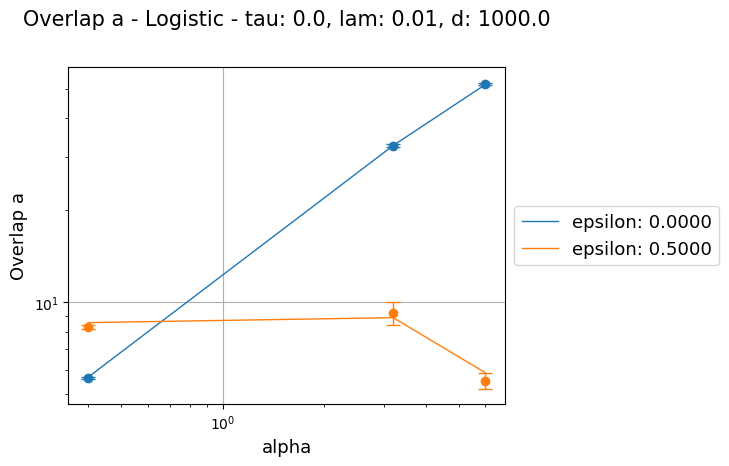

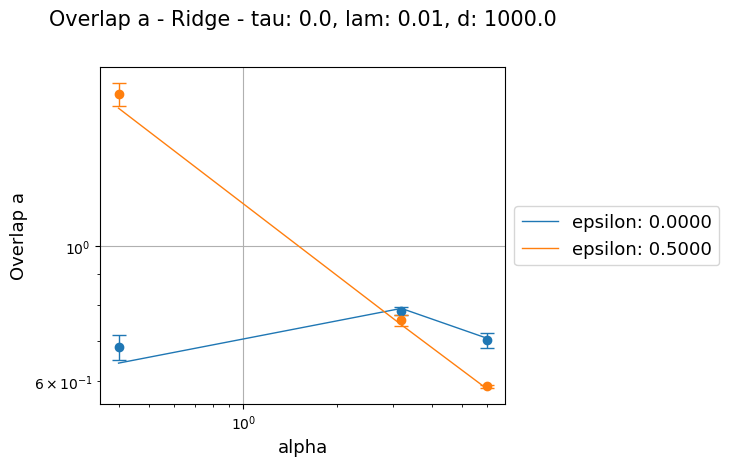

In [224]:
# Plot the a overlap
create_plot(df, "Overlap a", "A_state_evolution","A_erm", log_y=True)

In [225]:
# Plot the N_self overlap
# create_plot(df, "N_self", "N_self_state_evolution","N_erm", log_y=False)

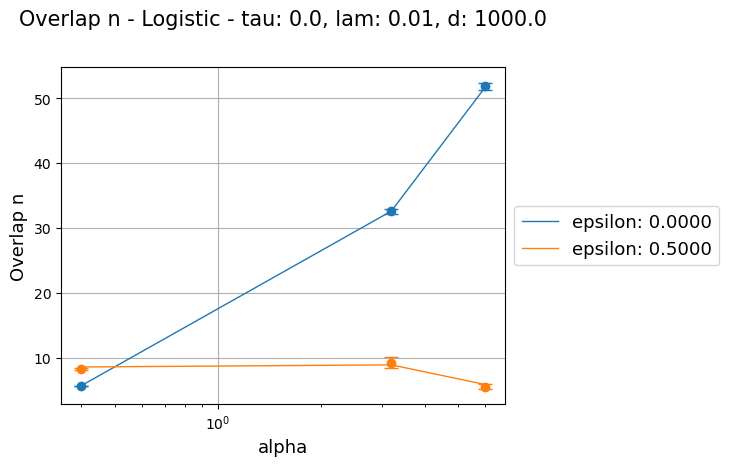

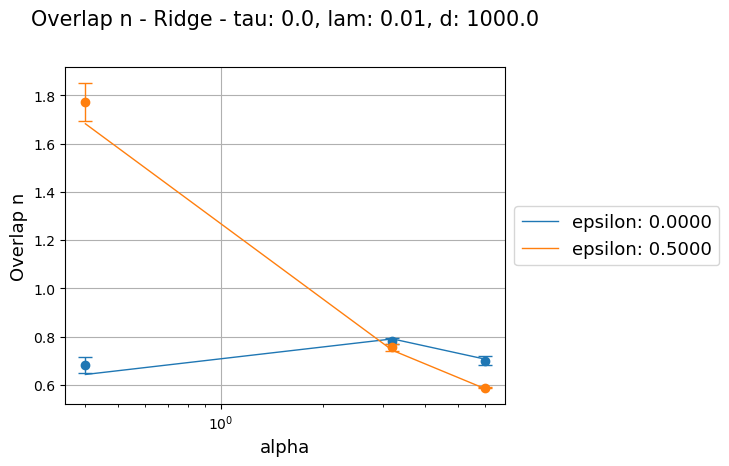

In [226]:
# Plot the n overlap
create_plot(df, "Overlap n", "N_state_evolution","N_erm", log_y=False)

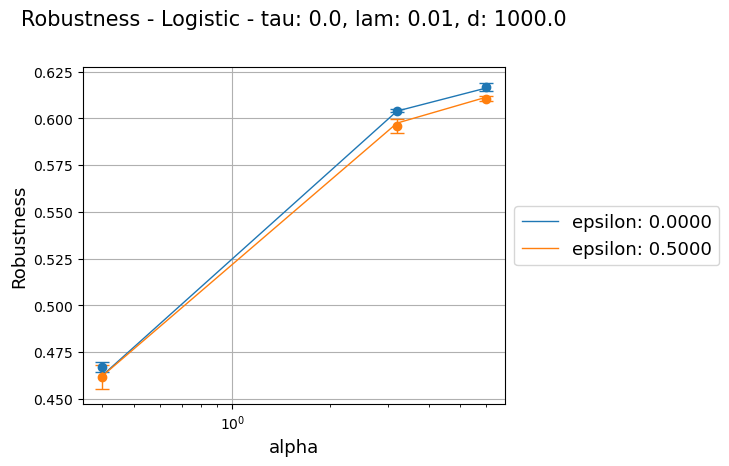

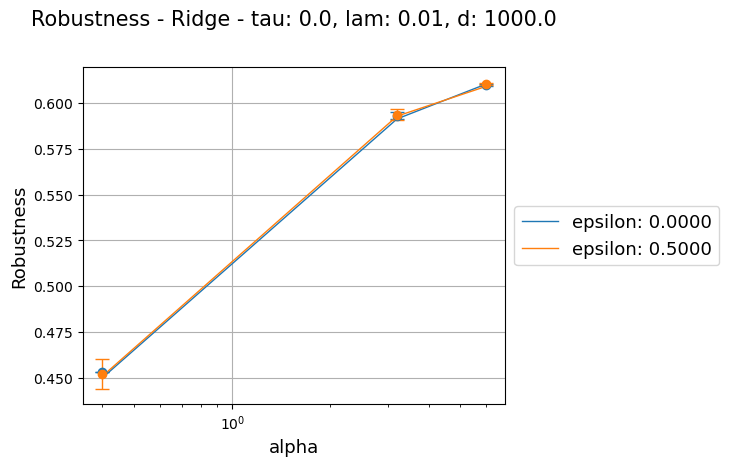

In [227]:
# Plot the robustness
create_plot(df, "Robustness", "robustness_state_evolution","robustness_erm", log_y=False)

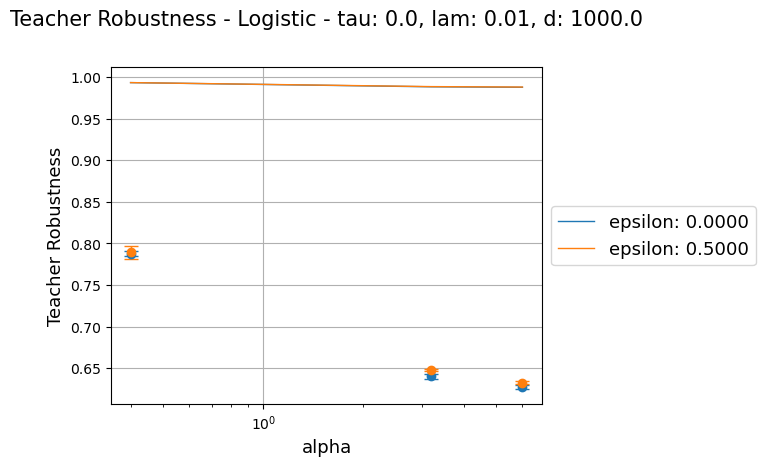

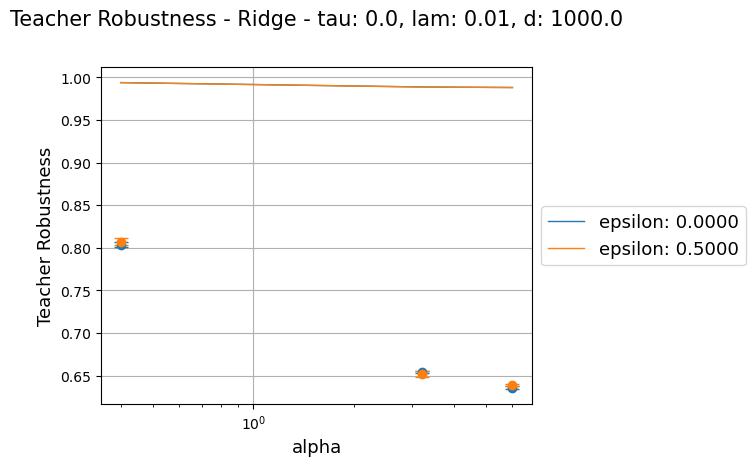

In [228]:
# Plot the teacher robustness
create_plot(df, "Teacher Robustness", "teacher_robustness_state_evolution","teacher_robustness_erm", log_y=False)

In [229]:
# # subset df to keep only where p = 0.5
# p = 0.6
# dfp = df[df.index.get_level_values("p_calibration") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

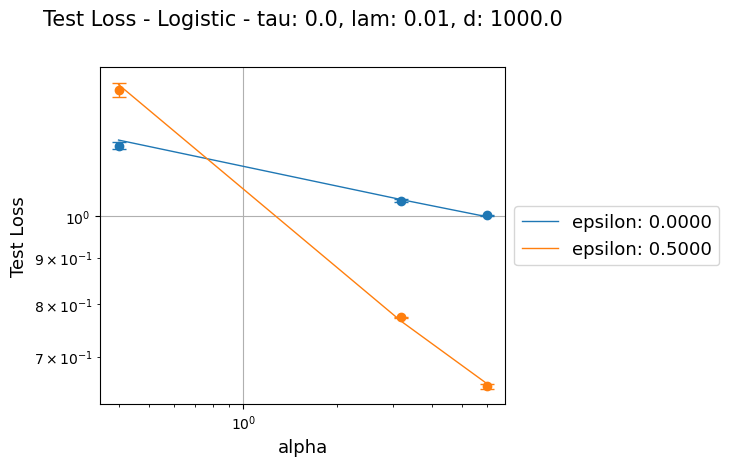

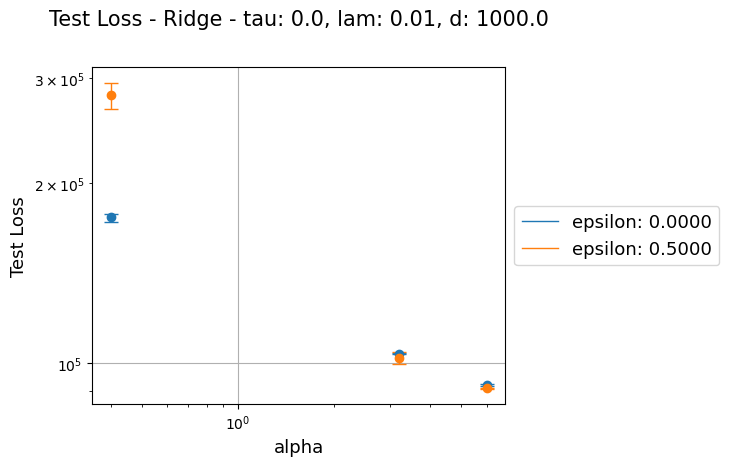

In [230]:
# plot test loss erm
create_plot(df, "Test Loss", "test_loss_state_evolution","test_loss_erm",log_y=True)

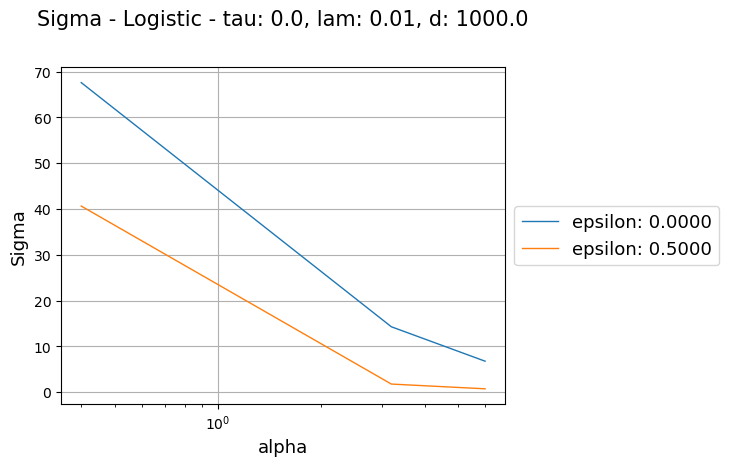

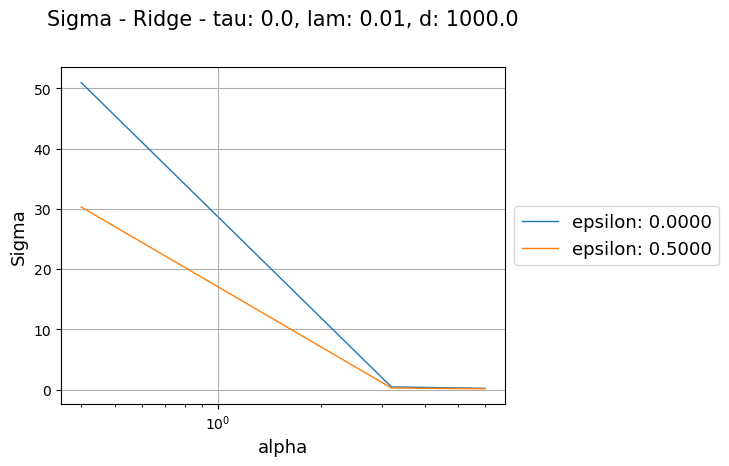

In [231]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None, log_y=False)

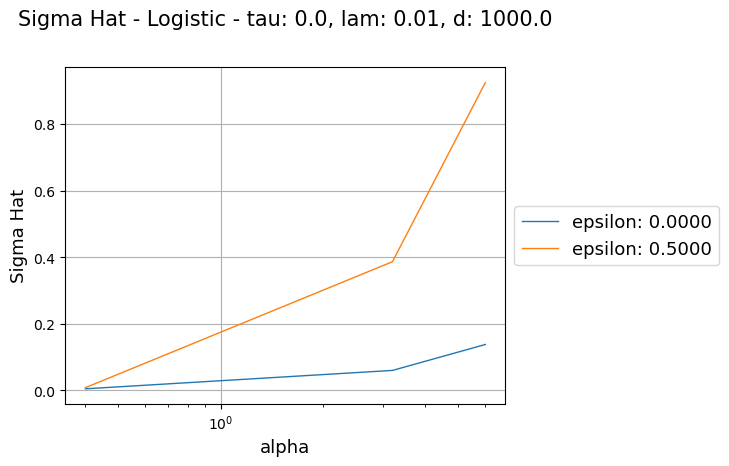

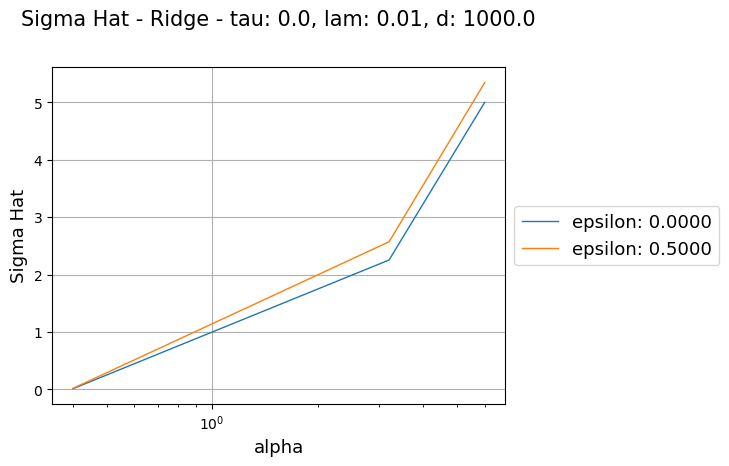

In [232]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None, log_y=False)

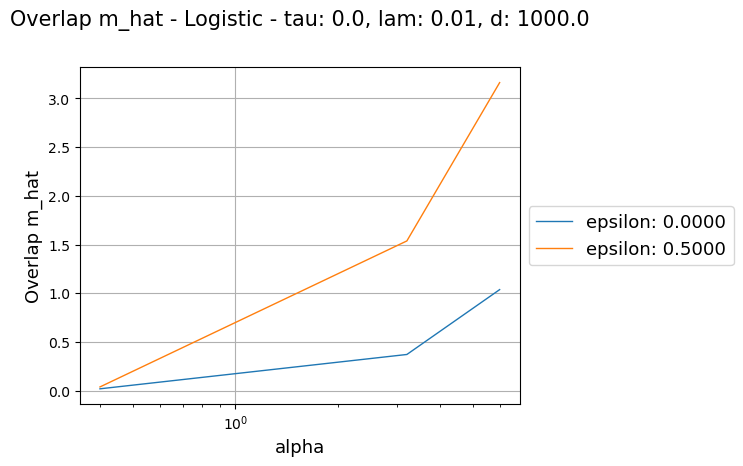

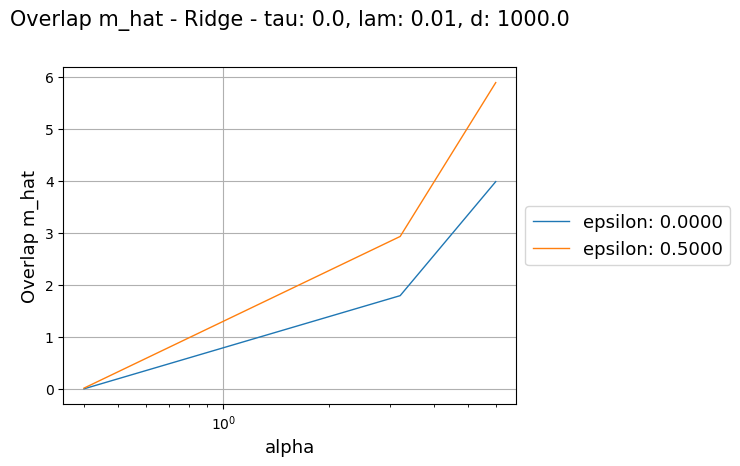

In [233]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None, log_y=False)

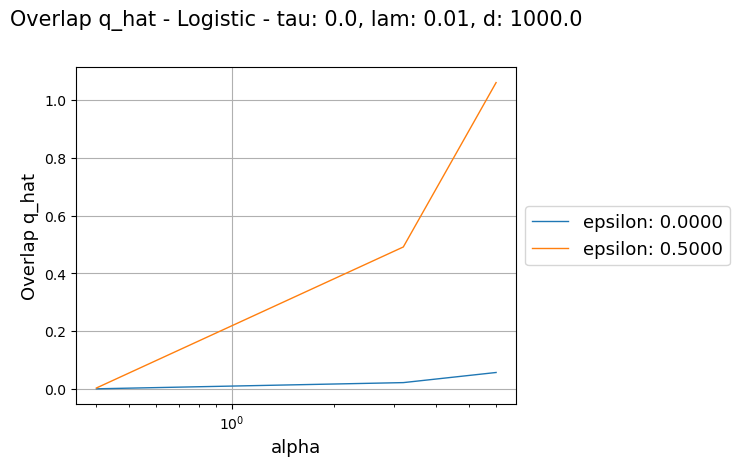

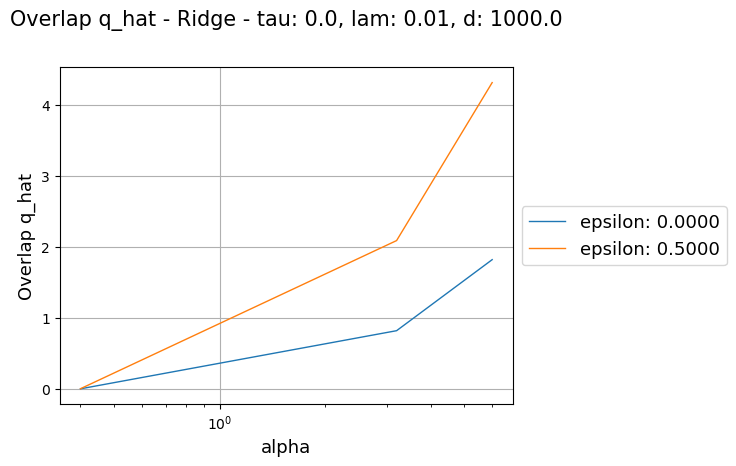

In [234]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None, log_y=False)

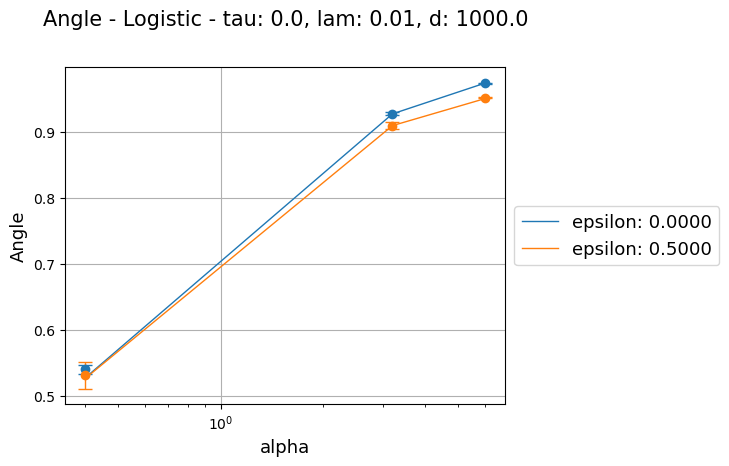

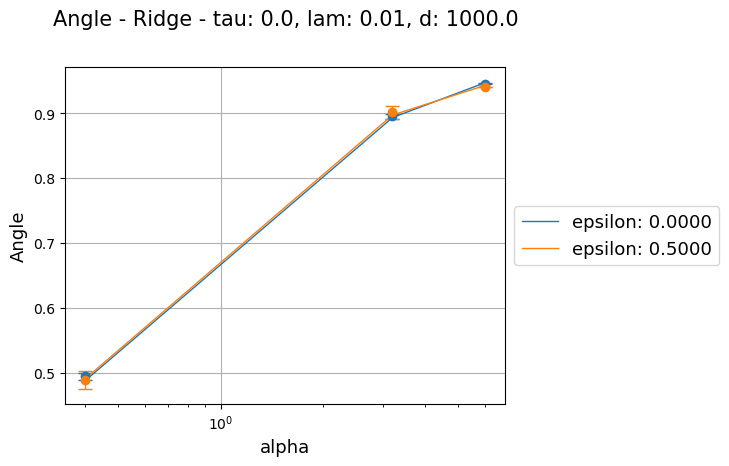

In [235]:
create_plot(df, "Angle", "angle_state_evolution","angle_erm",log_y=False)

## Log-Log Plots of overlaps in State_evolution

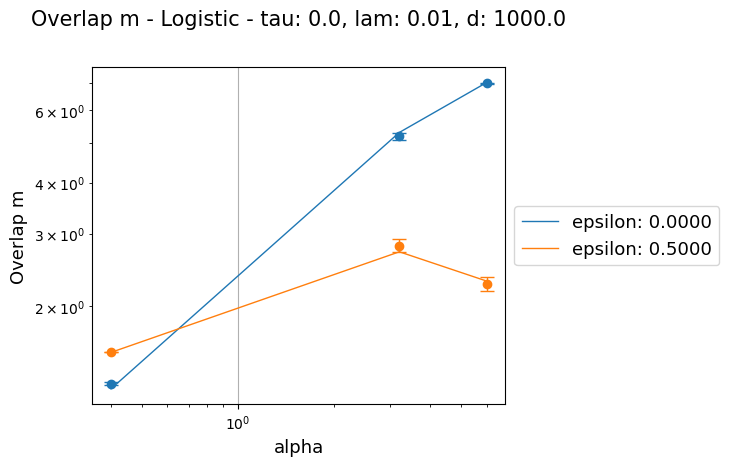

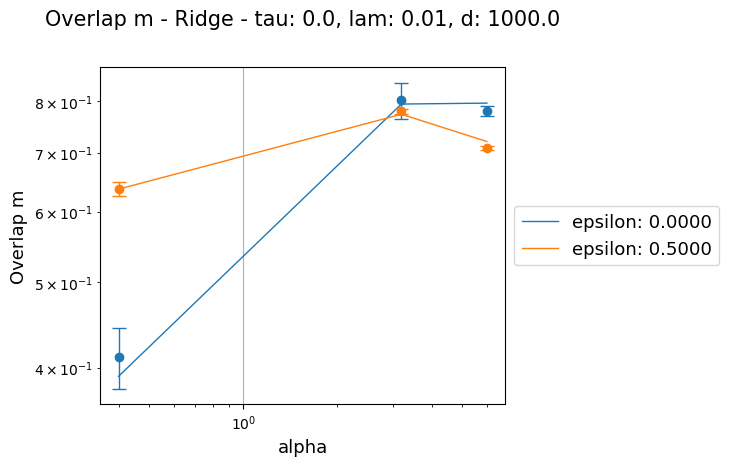

In [236]:
# create a log-log plot of the overlap m
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_x=True, log_y=True)

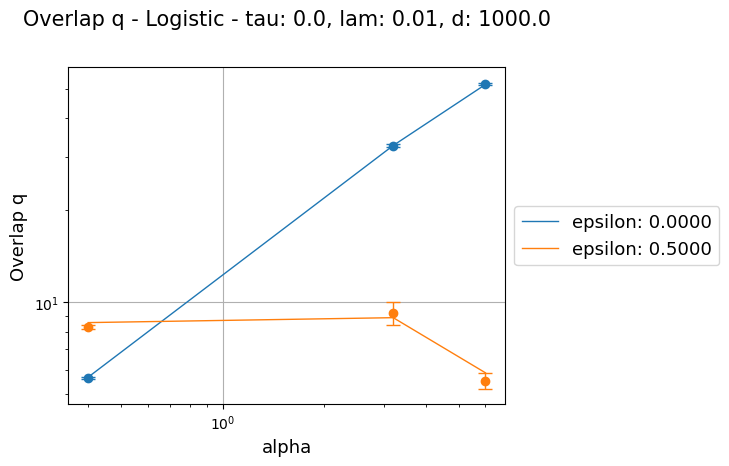

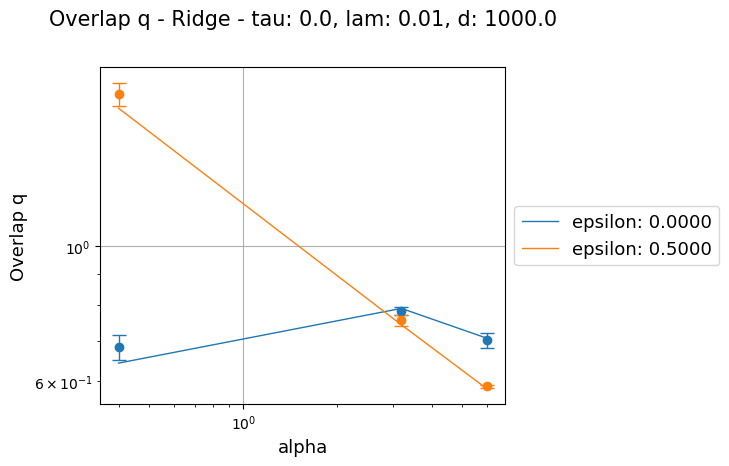

In [237]:
# create a log-log plot of the overlap q
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_x=True, log_y=True)

In [238]:
# create a log-log plot of the overlap sigma
# create_plot(df, "Overlap sigma", "sigma_state_evolution",None, log_x=True, log_y=True)

In [239]:
# create a log-log plot of the overlap sigma_hat
# create_plot(df, "Overlap sigma_hat", "sigma_hat_state_evolution",None, log_x=True, log_y=True)

In [240]:
# create a log-log plot of the overlap q_hat
# create_plot(df, "Overlap q_hat", "q_hat_state_evolution",None, log_x=True, log_y=True)

In [241]:
# create a log-log plot of the overlap m_hat
# create_plot(df, "Overlap m_hat", "m_hat_state_evolution",None, log_x=True, log_y=True)